In [72]:
import pandas as pd
import pyarrow

easy_data = pd.read_parquet("../data/super_easy/track2_data.parquet")
hard_data = pd.read_parquet("../data/hard/track2_data.parquet")
easy_move = pd.read_parquet("../data/super_easy/ground_truth.parquet")
hard_move = pd.read_parquet("../data/hard/ground_truth.parquet")

In [73]:
hard_move

,time_s,vx,vy,click,phase,vx_pos_center_row,vx_pos_center_col,vx_neg_center_row,vx_neg_center_col,vy_pos_center_row,vy_pos_center_col,vy_neg_center_row,vy_neg_center_col,click_center_row,click_center_col
0,0.000,6.854617,-6.752880,False,easy,16.0,22.0,16.0,10.0,10.0,16.0,22.0,16.0,16.0,16.0
1,0.002,3.760951,-1.326380,False,easy,16.0,22.0,16.0,10.0,10.0,16.0,22.0,16.0,16.0,16.0
2,0.004,9.995277,-2.490553,False,easy,16.0,22.0,16.0,10.0,10.0,16.0,22.0,16.0,16.0,16.0
3,0.006,11.338238,-0.460143,False,easy,16.0,22.0,16.0,10.0,10.0,16.0,22.0,16.0,16.0,16.0
4,0.008,18.893089,-3.493882,False,easy,16.0,22.0,16.0,10.0,10.0,16.0,22.0,16.0,16.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149995,299.990,-8.352909,-72.981026,False,stable,16.0,22.0,16.0,10.0,10.0,16.0,22.0,16.0,16.0,16.0
149996,299.992,-4.710714,-69.689674,False,stable,16.0,22.0,16.0,10.0,10.0,16.0,22.0,16.0,16.0,16.0
149997,299.994,-2.878211,-71.256866,False,stable,16.0,22.0,16.0,10.0,10.0,16.0,22.0,16.0,16.0,16.0
149998,299.996,-5.317026,-75.649445,False,stable,16.0,22.0,16.0,10.0,10.0,16.0,22.0,16.0,16.0,16.0


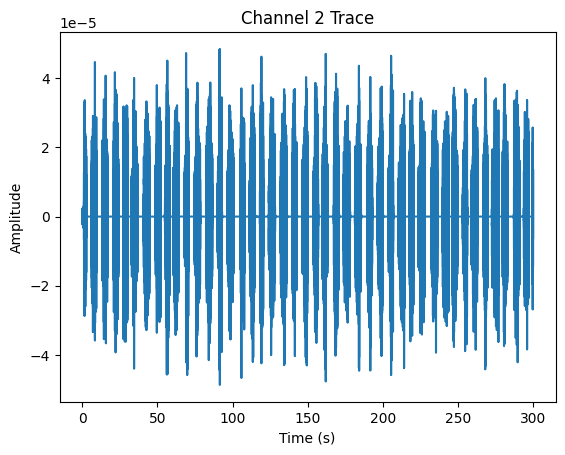

In [64]:
import matplotlib.pyplot as plt

# Replace 'data' with your actual variable name (e.g., easy_data or hard_data)
# This uses the 'time_s' index automatically for the x-axis
easy_data[180].plot(title="Channel 2 Trace", xlabel="Time (s)", ylabel="Amplitude")
plt.show()

In [44]:
import matplotlib.pyplot as plt

def plot_channel_spectrogram(df, channel_idx, fs=500, t_start=None, t_end=None):
    # Slice dataframe to time range (defaults to entire duration if None)
    subset = df.loc[t_start:t_end]
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    
    # 1. Raw Trace
    ax1.plot(subset.index, subset[channel_idx], linewidth=0.5)
    ax1.set_title(f"Channel {channel_idx} Raw Trace")
    ax1.set_ylabel("Amplitude")
    
    # 2. Spectrogram
    # xextent aligns the spectrogram x-axis with the dataframe's time index
    ax2.specgram(subset[channel_idx], NFFT=256, Fs=fs, noverlap=128, cmap='jet',
                 xextent=[subset.index.min(), subset.index.max()])
    
    ax2.set_title("Spectrogram")
    ax2.set_ylabel("Frequency (Hz)")
    ax2.set_xlabel("Time (s)")
    
    plt.tight_layout()
    plt.show()

# Usage Examples:
# plot_channel_spectrogram(hard_data, 0)                  # Whole period
# plot_channel_spectrogram(hard_data, 0, t_start=10, t_end=15)  # 10s to 15s

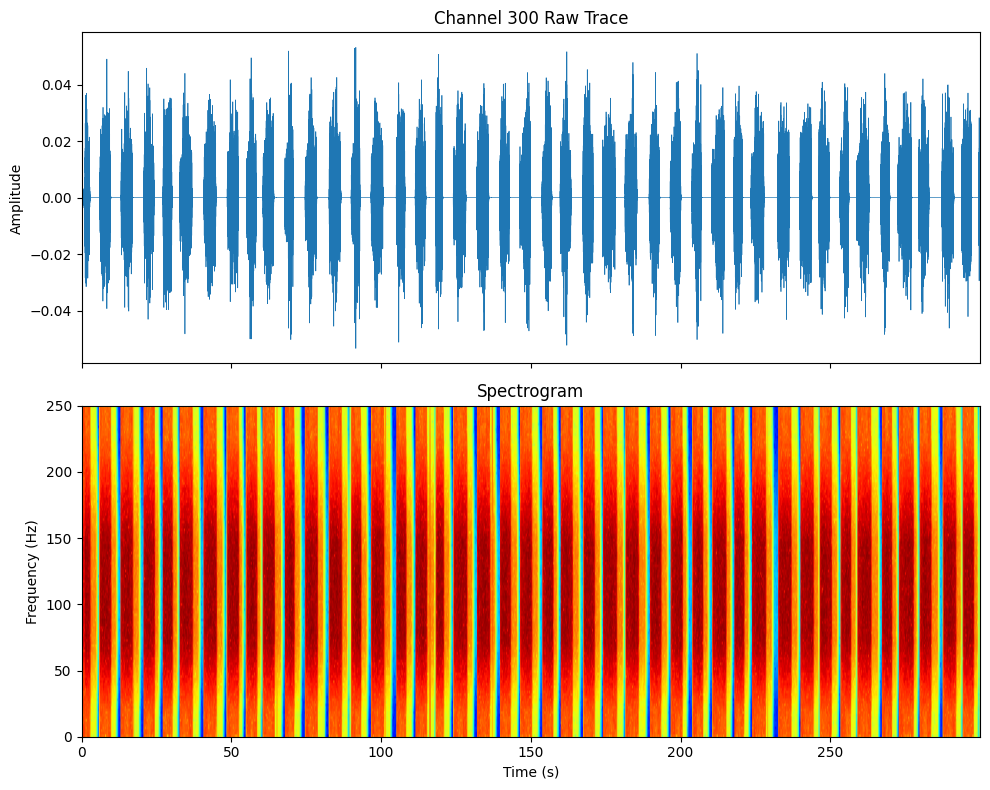

In [70]:
plot_channel_spectrogram(easy_data, 300)

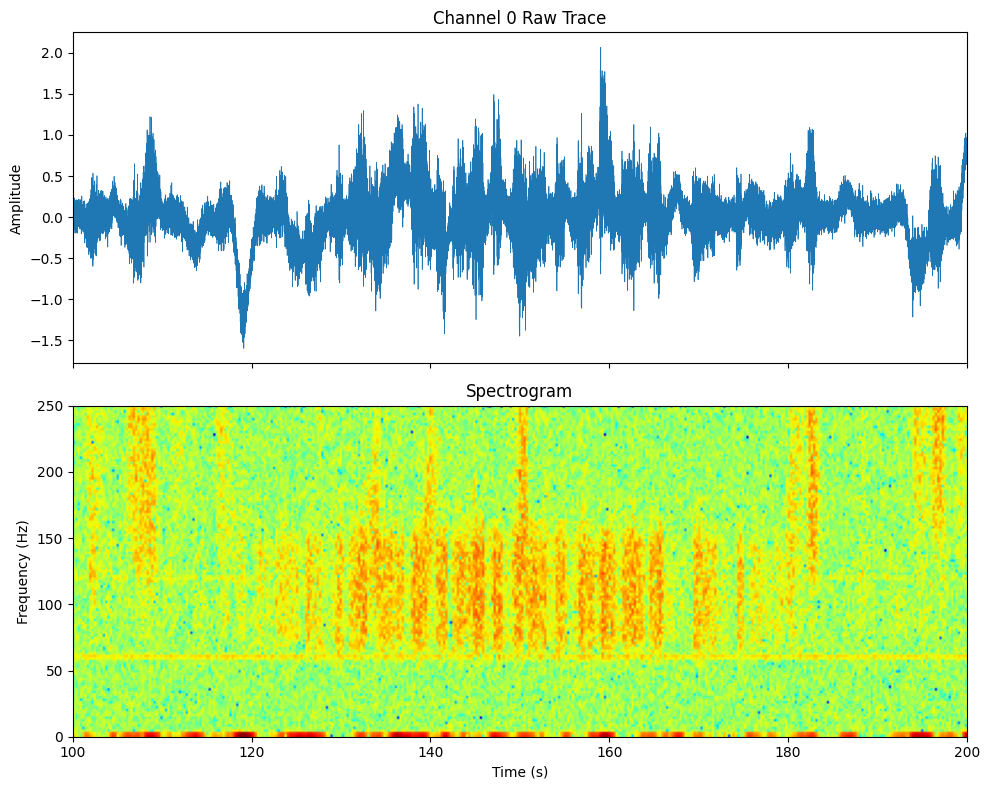

In [69]:
plot_channel_spectrogram(hard_data, 0, t_start=100, t_end=200)

In [55]:
from scipy import signal
import pandas as pd

def preprocess_signals(df, fs=500):
    """
    Applies Notch Filter (60Hz), Common Average Reference (CAR), and Linear Detrending.
    """
    # 1. Notch Filter (60 Hz)
    # Q=30 concentrates the filter narrowly around 60Hz to preserve other data
    b, a = signal.iirnotch(w0=60.0, Q=30.0, fs=fs)
    # filtfilt applies the filter forward and backward (zero-phase distortion)
    filtered_matrix = signal.filtfilt(b, a, df.values, axis=0)
    
    # Rebuild DataFrame to keep indices/columns safe
    df_clean = pd.DataFrame(filtered_matrix, index=df.index, columns=df.columns)

    # 2. Common Average Reference (CAR)
    # Subtract the average of all channels from every channel at each timepoint
    df_clean = df_clean.sub(df_clean.mean(axis=1), axis=0)

    # 3. Detrend
    # Remove linear trend from each channel
    # comment for now since it is not very important rn
    # df_clean[:] = signal.detrend(df_clean.values, axis=0, type='linear')
    
    return df_clean

# Usage:
# clean_data = preprocess_signals(hard_data)
# plot_channel_spectrogram(clean_data, 0)

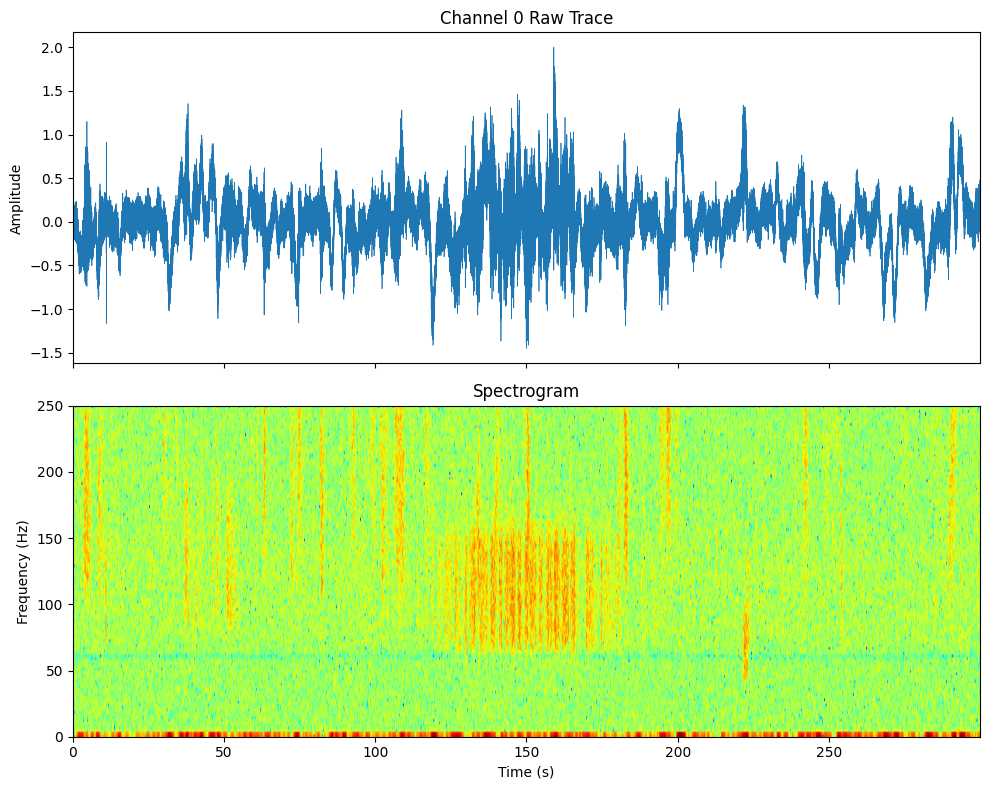

In [56]:
plot_channel_spectrogram(preprocess_signals(hard_data), 0)

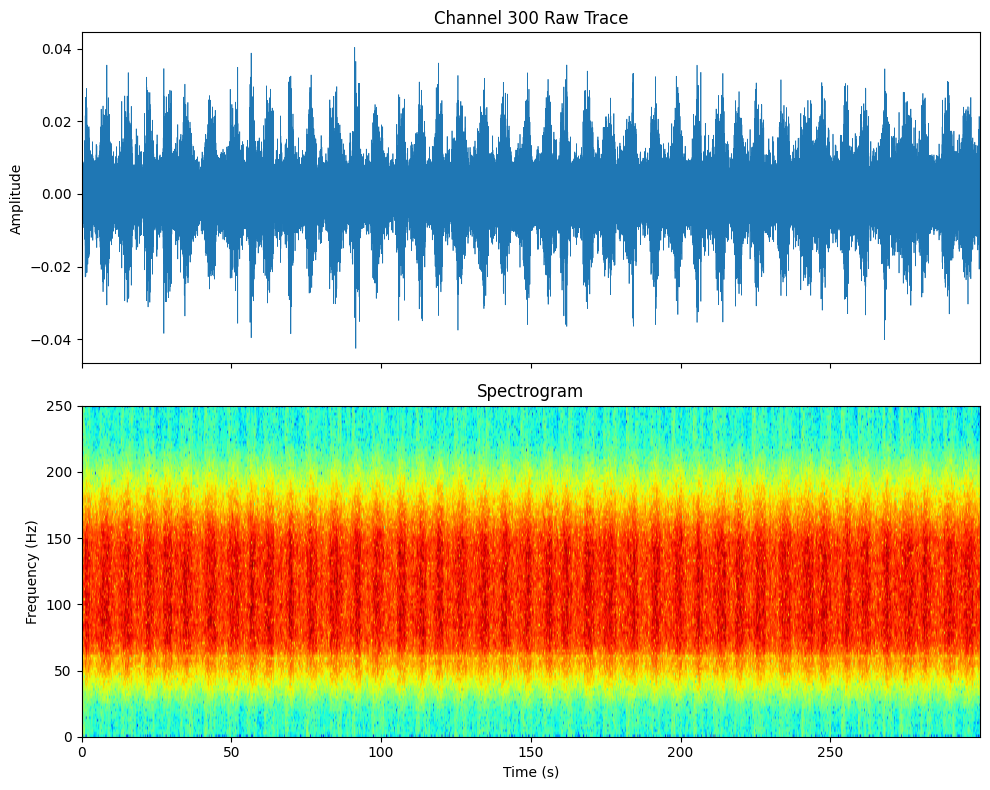

In [71]:
plot_channel_spectrogram(preprocess_signals(easy_data), 300)